In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from numpy.linalg import inv

sns.set_style('whitegrid')

In [4]:
def cov2corr(S):
    return S[0, 1] / np.sqrt(S[0, 0] * S[1, 1])

blue = pd.read_csv("bluecrab.dat", names=["body","rear"], delimiter=" ")
orange = pd.read_csv("orangecrab.dat", names=["body","rear"], delimiter=" ")

In [10]:
burn_ins = 2000
n_epochs = 10000

# prior parameters
mu0 = blue.mean().values
A0 = S0 = blue.cov().values
v0 = 4

# Blue posterior
N = blue.shape[0]
S = blue.cov()

blue_samples = []
for epoch in range(n_epochs + burn_ins):
    v_n = v0 + N
    S_n = S0 + S
    sigma_pos_rv = stats.invwishart(df=v_n, scale=S_n)

    Σ = sigma_pos_rv.rvs()
    Σ_n = inv(inv(A0) + N*inv(Σ))
    μ_n = Σ_n @ (inv(A0)@mu0 + N*inv(Σ)@blue.mean())

    theta_pos_rv = stats.multivariate_normal(μ_n, Σ_n)
    θ = theta_pos_rv.rvs()

    if epoch < burn_ins:
        continue 
    else:
        blue_samples.append((θ, Σ))
    

# Orange posterior
N = orange.shape[0]
S = orange.cov()

orange_samples = []
for epoch in range(n_epochs + burn_ins):
    v_n = v0 + N
    S_n = S0 + S
    sigma_pos_rv = stats.invwishart(df=v_n, scale=S_n)

    Σ = sigma_pos_rv.rvs()
    Σ_n = inv(inv(A0) + N*inv(Σ))
    μ_n = Σ_n @ (inv(A0)@mu0 + N*inv(Σ)@orange.mean())

    theta_pos_rv = stats.multivariate_normal(μ_n, Σ_n)
    θ = theta_pos_rv.rvs()

    if epoch < burn_ins:
        continue 
    else:
        orange_samples.append((θ, Σ))

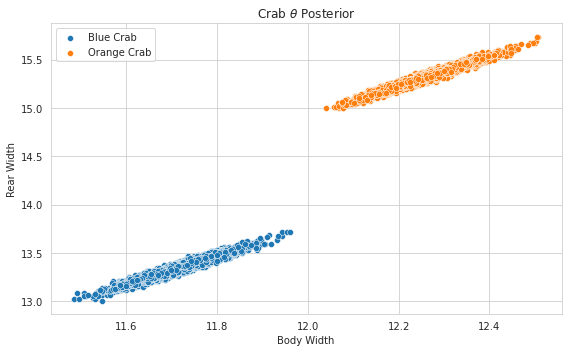

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))

X = np.array([s[0] for s in blue_samples])
sns.scatterplot(x=X[:,0], y=X[:,1], ax=ax, label='Blue Crab')

X = np.array([s[0] for s in orange_samples])
sns.scatterplot(x=X[:,0], y=X[:,1], ax=ax, label='Orange Crab')

ax.set_title('Crab $\\theta$ Posterior')
ax.set_xlabel("Body Width")
ax.set_ylabel("Rear Width")

# figure setups
fig.tight_layout()
fig.show()

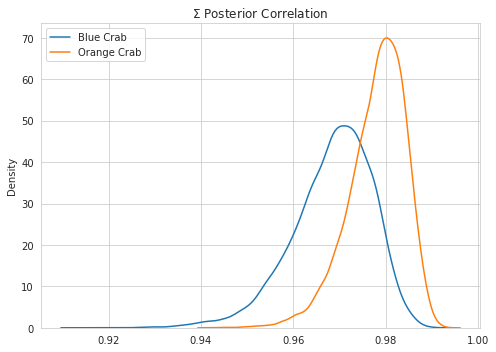

In [30]:
fig, ax = plt.subplots(figsize=(7, 5))

bs = np.array([cov2corr(s[1]) for s in blue_samples])
os = np.array([cov2corr(s[1]) for s in orange_samples])

sns.kdeplot(bs, label='Blue Crab', ax=ax)
sns.kdeplot(os, label='Orange Crab', ax=ax)

ax.set_title("$\\Sigma$ Posterior Correlation")
ax.legend()
fig.tight_layout()
fig.show()

In [23]:
(bs < os).mean()

0.8299